[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1lyFctK8BsKNVpXVgjtCknkAWJx8tXRun?usp=sharing)

# Clustering and PCA on Country Dataset (Task 7)

In [1]:
import pandas as pd # Allow us to work with CSV files
import numpy as np # Allow us to work with arrays
import matplotlib.pyplot as plt # Allow us to customize Histograms
import math # Allow us to perform mathematical tasks
from sklearn.preprocessing import StandardScaler # Allow us to perform standardization
from sklearn.decomposition import PCA, IncrementalPCA # Allow us to perform PCA technique 
from sklearn import cluster, metrics # Allow us to perform K-means Clustering and Metrics
import seaborn as sns # Import Seaborn visualization library

In [2]:
# Step 1: Loading the "country-data.csv" file

df_country = pd.read_csv('https://raw.githubusercontent.com/sagihaider/CE888_2021/main/Lab_6/Data/Country-data.csv') # Read a CSV file from internet (Github)

print('Country dataset (truncated)')
display(df_country)      # Print the country dataset (truncated)

Country dataset (truncated)


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


In [3]:
# Step 1: Loading the "data-dictionary.csv" file

df_dict = pd.read_csv('https://raw.githubusercontent.com/sagihaider/CE888_2021/main/Lab_6/Data/data-dictionary.csv') # Read a CSV file from internet (Github)

# The dictionary dataset contains the description of each of the features in the dataset
print('Dictionary dataset (truncated)\n')
display(df_dict.style.set_properties(subset=["Description"], **{'text-align': 'left'}))    # Print the Dictionary dataset (truncated)


# **{'text-align': 'left'}   This parameter aligns the values of one or more columns to the left 
# set_properties             This parameter is used to render or customize the content of the dataset.

Dictionary dataset (truncated)



,Column Name,Description
0,country,Name of the country
1,child_mort,Death of children under 5 years of age per 1000 live births
2,exports,Exports of goods and services per capita. Given as %age of the GDP per capita
3,health,Total health spending per capita. Given as %age of GDP per capita
4,imports,Imports of goods and services per capita. Given as %age of the GDP per capita
5,Income,Net income per person
6,Inflation,The measurement of the annual growth rate of the Total GDP
7,life_expec,The average number of years a new born child would live if the current mortality patterns are to remain the same
8,total_fer,The number of children that would be born to each woman if the current age-fertility rates remain the same.
9,gdpp,The GDP per capita. Calculated as the Total GDP divided by the total population.


In [4]:
# Step 2: Analyzing features (datatypes and Missing Values)

display(df_country.info()) # Get the datatypes and missing values of the columns

print('''\nAs we can see above, there is no missing values in the "Country" dataset.''')

# df.info()       This function is used to print a concise summary of a dataframe. 
#                 This includes the index type, columns names, datatypes, non-null values and memory usage

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


None


As we can see above, there is no missing values in the "Country" dataset.


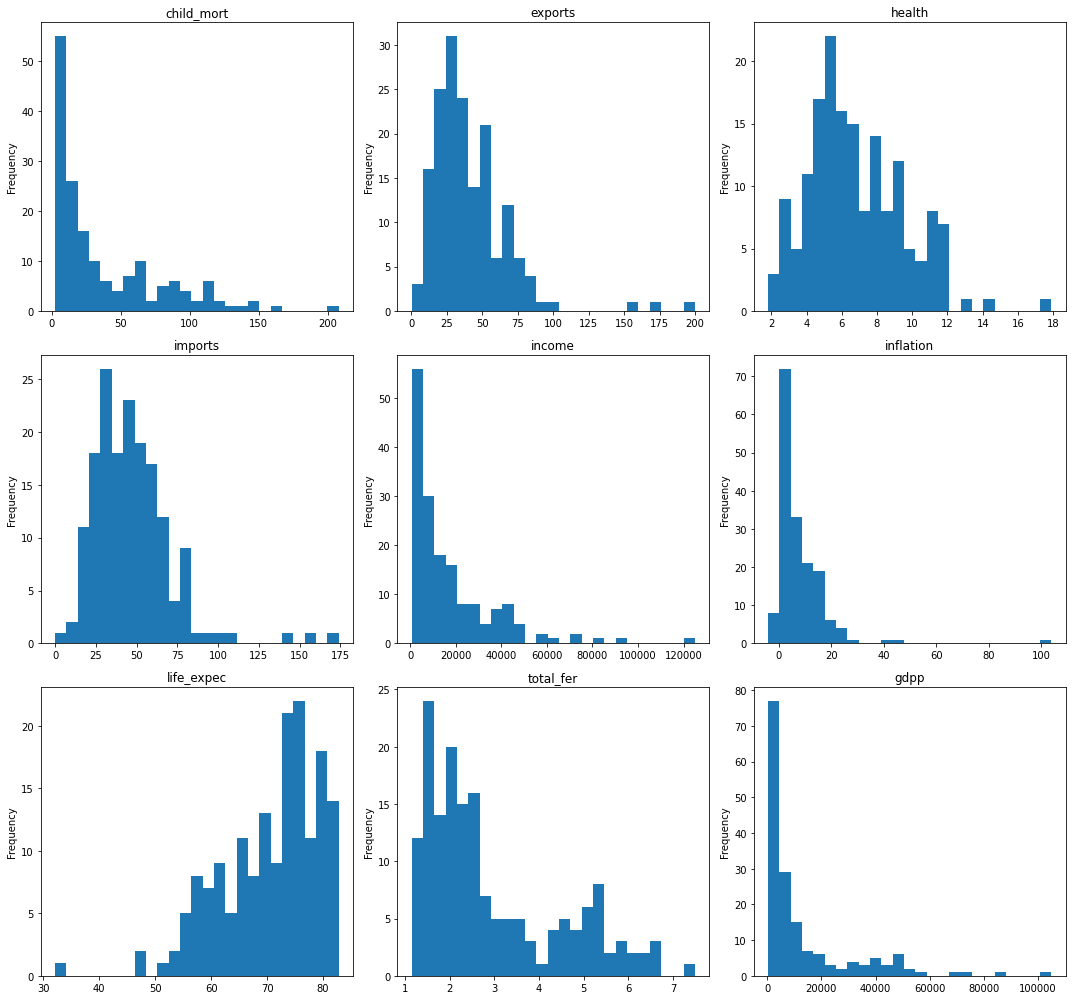

In [5]:
# Step 3: Visualizing the data and looking for outliers (part 1)

# Plotting a Histogram for each feature
n_row = 3                                              # Define the number of rows that will be displaying in the final output, which in this case is 3
n_col = 3                                              # Define the number of columns that will be displaying in the final output, which in this case is 3.
fig, axes = plt.subplots(n_row, n_col, figsize=(15,14))    # This function allows to customize the X-axis, Y-axis and size of the figure 
for i in range(df_country.shape[1]-1):                     # For-loop iterates over all columns found in the 'Country' dataframe with the exception of feature "Country"
  df_country.iloc[:,i+1].plot.hist(bins=25, ax=axes[math.floor(i/n_row), i-n_col*math.floor(i/n_row)], title=df_country.columns.values[i+1])
  # Plot a Histogram with the specified parameters for each attribute starting by column 1 and including all rows (country feature is ignored)

  #df_country.iloc[:,i+1].plot(kind='kde', ax=axes[math.floor(i/n_row), i-n_col*math.floor(i/n_row)], secondary_y=True)

plt.tight_layout()   # Adjust the histograms to avoid misplacings or pairing.
plt.show()           # Display the current figure that you are working on

# df.Shape[1]               This function is used to get the total number of columns in a dataframe
# df.iloc[row>,<column>]    This function is used to select a particular cell of a dataframe. (Selecting rows and columns by number)
# df.plt.hist()             This function is used to plot a histogram
# math.floor()              This function is used to round numbers down to the nearest integer (e.g. 20.6 -> 20)
# df.columns.values         This function is used to get all columns name as an array

As shown above, it is possible that some of the features contain potential outliers:
1. **Child_mort**: There is one country that has more than 200 in this column, which represents a lot of death of children under 5 years.
2. **exports**: There are some points located between 150 and 200. These values are far from almost the whole data.
3. **health**: There is a particular value that is roughly 18 and lies outside the overall distribution of the data. (≈18)
4. **imports**: There are 3 potential observations that are distant from the others. (150 - 175)
5. **income**: There are a couple of values that are separated from the crowd ( > 120,000)
6. **inflation**: There is one country that has more than 100 in the inflation attribute
7. **life_expect**: There is one point located nearly 33. This value is far from almost the whole data.
8. **gdp**: There are 2 potential observations that are distant from the others. (80,0000 - 100,000)


In [6]:
# Step 3: Visualizing the data and looking for outliers (part 2)

# Creating a function that finds all outliers in one column
def detect_outlier(data_1):
    outliers=[]                          # Create a new-empty list to store all the outliers of the feature
    threshold=3                          # Define the value that determines if a point is considered as outlier or not. In this case is 3σ 
    mean_1 = np.mean(data_1)             # Calculate the mean value of the whole column (feature)
    std_1 = np.std(data_1)               # Calculate the standard deviation value of the whole column (feature)
    
    for y in data_1:                     # For-loop iterates over all the values found in the whole column (feature)
        z_score = (y - mean_1)/std_1     # Calculate the Z score of each data point: (Observed mean - Sample mean / Sample standard deviation)
        if np.abs(z_score) > threshold:  # Condition: if absolute value of Z score is bigger than threshold (|Z|>3), then considered as outlier
            outliers.append(y)           # For each outlier encountered, add it to the list "outliers"
    return outliers

# np.mean          This function is used to calculate the mean value
# np.std           This function is used to calculate the standard deviation
# np.abs()         This function is used to calculate the absolute value of each element of the array. 

In [7]:
# Step 3: Visualizing the data and looking for outliers (part 3)

features_list = df_country.columns.to_list() # Get the names of the columns of "Country" dataset
X = features_list[1::] # This list of features will exclude the "country" column
print ('''These are the feature variables:
%s''' %(X))  # Print all the columns name of the "Country" dataset

# Displaying the detected outliers and the country that holds them
for i in X:                                                                                 # For-loop iterates over all the values found in list X (columns name)
  outlier_datapoints = detect_outlier(df_country[i])                                        # run the function "detect_outlier"
  print("\n\nThe detected outliers in %s feature are: %s" %(i, outlier_datapoints)+"\n")    # Output: detected outliers in given feature
  for outlier in outlier_datapoints:                                                        # For-loop iterates over all the values found in the outliers list
    display(df_country[['country',i]].loc[df_country[i] == outlier])                        # Output: Filter all rows containing the outlier in the specified column

# DataFrame.loc  This attribute access a group of rows and columns by label(s) or a boolean array in the given dataframe.
#                df.loc[df[] == 'string'] indicates: 
#                                         "get all rows that contains 'string' or number in the specified column
# df.columns.to_list().     This function is used to get the column names of a dataframe in a nice list.

These are the feature variables:
['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']


The detected outliers in child_mort feature are: [208.0, 160.0]



,country,child_mort
66,Haiti,208.0


,country,child_mort
132,Sierra Leone,160.0




The detected outliers in exports feature are: [175.0, 153.0, 200.0]



,country,exports
91,Luxembourg,175.0


,country,exports
98,Malta,153.0


,country,exports
133,Singapore,200.0




The detected outliers in health feature are: [17.9]



,country,health
159,United States,17.9




The detected outliers in imports feature are: [142.0, 154.0, 174.0]



,country,imports
91,Luxembourg,142.0


,country,imports
98,Malta,154.0


,country,imports
133,Singapore,174.0




The detected outliers in income feature are: [80600, 75200, 91700, 125000]



,country,income
23,Brunei,80600


,country,income
82,Kuwait,75200


,country,income
91,Luxembourg,91700


,country,income
123,Qatar,125000




The detected outliers in inflation feature are: [104.0, 45.9]



,country,inflation
113,Nigeria,104.0


,country,inflation
163,Venezuela,45.9




The detected outliers in life_expec feature are: [32.1]



,country,life_expec
66,Haiti,32.1




The detected outliers in total_fer feature are: [7.49]



,country,total_fer
112,Niger,7.49




The detected outliers in gdpp feature are: [105000, 87800, 70300, 74600]



,country,gdpp
91,Luxembourg,105000


,country,gdpp
114,Norway,87800


,country,gdpp
123,Qatar,70300


,country,gdpp
145,Switzerland,74600


In [8]:
# Step 4: Performing Feature Scaling (part 1)

# dropping column "country"
df_country1 = df_country.drop(columns=['country']) # Dropping specified column

print('Country dataset after dropping column "country" (truncated)\n')
display(df_country1) # Print Country dataframe after dropping column: "country"

Country dataset after dropping column "country" (truncated)



,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...
162,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


In [9]:
# Step 4: Performing Feature Scaling (part 2)

# Standardizing the dataset
scaler = StandardScaler()                             # Create the Standard Scaler object
country_scaled = scaler.fit_transform(df_country1)    # Transform and standardize the Country dataframe

df_scaled = pd.DataFrame(country_scaled, columns = [X]) # Convert the standardized array to a Dataframe
print('Country dataset after performing Standardization (truncated)\n')
display(df_scaled) # Print Country dataframe after performing standardization


Country dataset after performing Standardization (truncated)



,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817
...,...,...,...,...,...,...,...,...,...
162,-0.225578,0.200917,-0.571711,0.240700,-0.738527,-0.489784,-0.852161,0.365754,-0.546913
163,-0.526514,-0.461363,-0.695862,-1.213499,-0.033542,3.616865,0.546361,-0.316678,0.029323
164,-0.372315,1.130305,0.008877,1.380030,-0.658404,0.409732,0.286958,-0.661206,-0.637754
165,0.448417,-0.406478,-0.597272,-0.517472,-0.658924,1.500916,-0.344633,1.140944,-0.637754


As observed above, the whole dataset has been transformed to have zero mean and 1 standard deviation.

## Principal Component Analysis

Principal Component Analysis (PCA) is a Dimensionality Reduction technique usually used in large datasets with multiple dimensions, by transforming a large set of variables into a smaller one that still contains most of the information in the original dataset.

In [10]:
# Step 5: Performing Principal Component Analysis (PCA) (part 1)

pca = PCA(random_state=100) # Creating the PCA object with the specified parameters.
pca.fit(df_scaled) # Perform PCA on the Country dataset after standardization

# random_state           This parameter makes a solution easy to replicate. A definite value of random_state will always produce 
#                        same results if given with same parameters and training data

PCA(copy=True, iterated_power='auto', n_components=None, random_state=100,
    svd_solver='auto', tol=0.0, whiten=False)

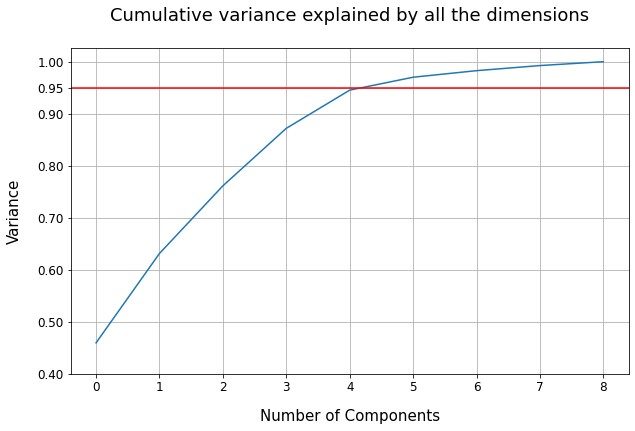

In [11]:
# Step 5: Performing Principal Component Analysis (PCA) (part 2)

# Plotting the cumulative variance against the number of components
fig = plt.figure(figsize = (10,6))                         # This parameter is used to adjust the size of the graph
chart = plt.plot(np.cumsum(pca.explained_variance_ratio_)) # Creates the cumulative variance chart
 
y_val = [0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]                         # Customize the label values in Y-Axis

plt.xticks(size=12)                                              # This X-Axis property allows us to customize the values of the labels in X-axis
plt.yticks(y_val, size=12)                                       # This Y-Axis property allows us to customize the values of the labels in Y-axis

plt.xlabel('Number of Components', fontsize = 15, labelpad=15)   # This X-Axis property allows us to customize the labels of X-axis
plt.ylabel('Variance', fontsize = 15, labelpad=15)               # This Y-Axis property allows us to customize the labels of Y-axis

# Draw a horizontal line with particular specifications: 
plt.axhline(0.95, color='r')   # In Y-Axis: start at value: 0.95 and finishes at the largest value in X-axis)

plt.title('Cumulative variance explained by all the dimensions\n', fontsize = 18)       # Add a title to the cumulative chart
plt.grid()   # Draw a grid in the chart
plt.show()   # Display the current figure that we are working on

# pca.explained_variance_ratio_     This parameter returns a vector of the variance explained by each dimension.
# np.cumsum()                       This function is used to compute the cumulative sum of array elements over a given axis.
#                                   In this case, this will return the cumulative variance explained by all the dimensions.
# labelpad                          This parameter is used to increase the distance between the axis values and the axis labels

As shown above, the Cumulative Variance chart concluded that the **optimal number of Principal Components** are **4**. <br>
Compared with the the original dataset tha has 9 dimensions, PCA have reduced the features to 4 and still be able to explain 95% of the variance of the dataset.

In [12]:
# Step 5: Performing Principal Component Analysis (PCA) (part 3)

# Transform the Country dataset after standardization to 4 PCA components
pca_final = IncrementalPCA(n_components=4) # Create the PCA data with the specified number of components. (In this case is 4)
country_pca = pca_final.fit_transform(df_scaled) # Transform the Country dataset after standardization to a new PCA dataframe with 4 PCA components

# Create a new dataframe with 4 PCA components
df_country_pca = pd.DataFrame(country_pca, columns = ['principal component 1', 'principal component 2', 'principal component 3','principal component 4',])
print('PCA Country dataset (truncated)\n')
display(df_country_pca) # Print the PCA Country dataframe

PCA Country dataset (truncated)



,principal component 1,principal component 2,principal component 3,principal component 4
0,-2.913787,0.088354,0.721003,0.996699
1,0.429358,-0.587859,0.321052,-1.171193
2,-0.282988,-0.446657,-1.225135,-0.850127
3,-2.930969,1.699437,-1.521734,0.875966
4,1.031988,0.130488,0.192922,-0.844808
...,...,...,...,...
162,-0.822887,0.629074,0.343214,-0.701375
163,-0.537432,-1.177328,-2.922300,-0.126091
164,0.502767,1.408012,0.322218,-1.116014
165,-1.882505,-0.093454,-1.055348,0.056400


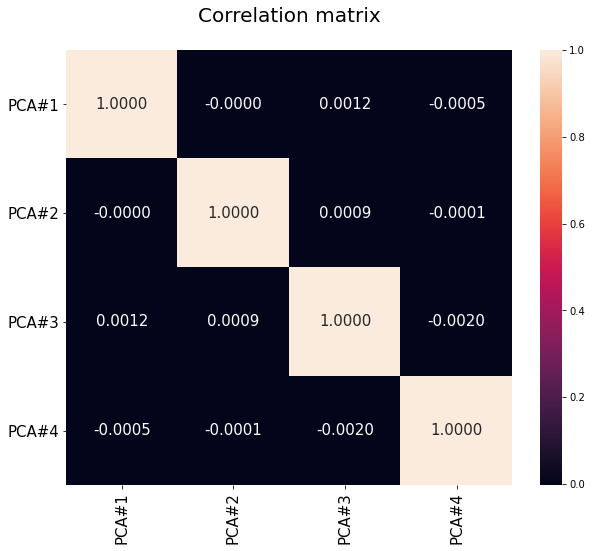

In [13]:
# Step 5: Performing Principal Component Analysis (PCA) (part 4)

# Plotting the PCA correlation (there should not be any significant correlation between the PCs)
plt.figure(figsize=(10, 8))                                                        # Change the size of the graph
ax= plt.subplot()                                                                  # This function allows us to customize the X-axis and Y-axis of the figure
sns.heatmap(df_country_pca.corr(), annot = True, annot_kws={"size":15}, fmt=".4f") # Create the correlation chart with the specified parameters
ax.xaxis.set_ticklabels(['PCA#1', 'PCA#2', 'PCA#3', 'PCA#4'], fontsize = 15)       # This X-Axis property allows us to customize the labels of X-axis
ax.yaxis.set_ticklabels(['PCA#1', 'PCA#2', 'PCA#3', 'PCA#4'], fontsize = 15)       # This Y-Axis property allows us to customize the labels of Y-axis

plt.title('Correlation matrix\n', fontsize=20)      # Add a title to the correlation chart
plt.show()                                          # Display the current figure that we are working on

# df.corr()                           This function is used to get the pairwise correlation of all columns in the dataframe.
# annot = true                        This parameter is used to write the data value in each cell of the correlation chart 
# annot_kws={"size":15}, fmt=".4f")   This parameter specifies the font size and format of the annotation. 
#                                     In this case, the value of each cell will have 4 decimal digits and a fontsize of 15.

As shown above, the correlation coefficients are 0, which means that multicollinearity has been removed in our data. <br>
In other words, there is no correlation between the Principal Components. 




In [14]:
# Step 5: Performing Principal Component Analysis (PCA) (part 5)

# Get only the Country column fron Country dataset
df_country2 = df_country[['country']] 

print('Column Country dataset (truncated)\n')
display(df_country2) # Print the column country dataframe

Column Country dataset (truncated)



,country
0,Afghanistan
1,Albania
2,Algeria
3,Angola
4,Antigua and Barbuda
...,...
162,Vanuatu
163,Venezuela
164,Vietnam
165,Yemen


In [15]:
# Step 5: Performing Principal Component Analysis (PCA) (part 6)

# Merging the dataframes PCA Country and Column Country
df_country_pca1 = pd.concat([df_country2, df_country_pca], axis=1)  # Merging the dataframes

print('Final PCA Country dataset (truncated)\n')
display(df_country_pca1) # Print the Final PCA Country dataframe

# .concact()      This function is used to concatenate two different dataframes.
# Axis=1          This parameter indicates column-wise concatenation (Merging columns of two different dataframes)

Final PCA Country dataset (truncated)



,country,principal component 1,principal component 2,principal component 3,principal component 4
0,Afghanistan,-2.913787,0.088354,0.721003,0.996699
1,Albania,0.429358,-0.587859,0.321052,-1.171193
2,Algeria,-0.282988,-0.446657,-1.225135,-0.850127
3,Angola,-2.930969,1.699437,-1.521734,0.875966
4,Antigua and Barbuda,1.031988,0.130488,0.192922,-0.844808
...,...,...,...,...,...
162,Vanuatu,-0.822887,0.629074,0.343214,-0.701375
163,Venezuela,-0.537432,-1.177328,-2.922300,-0.126091
164,Vietnam,0.502767,1.408012,0.322218,-1.116014
165,Yemen,-1.882505,-0.093454,-1.055348,0.056400


## K-Means Clustering

K-means Clustering is one of the simplest and popular unsupervised machine learning algorithms. <br>The Number of K (Clusters) is the only parameter that is necessary to be defined in this ML model.
<br>

Nevertheless, the **task 7 of lab 6** mentions that the **number of clusters** in this work should be equal to **3**:

| S.No      | Categories |
| ----------- | ----------- |
| 1   | Under-developing country |
| 2   | Developing country       |
| 3   | Developed country        |

In [16]:
# Clustering using K Means Algorithm (Part 1)

np.set_printoptions(threshold=np.inf, precision=3, suppress=True, linewidth=100) # Print all the values of an array as a pretty table (all values in one row)

# Creating the K-means object with the specified parameters:
km_model = cluster.KMeans(n_clusters=3, random_state=34, max_iter=1000)

# n_clusters        This parameter is used to set the number of clusters to form and the number of centroids to generate.
#                   In this case, K is equal to 3 because we already know that there are three classes ("Under-developing country","Developing country","Developed country").
# random_state      This parameter makes a solution easy to replicate. A definite value of random_state will always produce same results if given with same parameters and training data
# max_iter          This function indicates the maximum number of iterations of the k-means algorithm for a single run.

# Training the K-means object
km_model.fit(df_country_pca) # Train the K-means algorithm with the PCA dataset
km_model.labels_ # Output: Cluster predictions.

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0, 1, 2, 1, 0, 0, 1, 0, 2, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 2, 1,
       1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0, 0, 1, 1, 2, 1,
       0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 2, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 2, 2,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 2, 2, 2, 1, 0, 2, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0], dtype=int32)

In [17]:
# Clustering using K Means Algorithm (Part 2)

df_country['labels_kmeans'] = km_model.labels_  # Add the cluster predictions to the original Country dataframe

print('Country Dataset with Cluster predictions (truncated)\n')
display(df_country) # Print the Country dataframe with Cluster predictions

Country Dataset with Cluster predictions (truncated)



,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,labels_kmeans
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,1
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,1
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,1
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,0


### Countries in **Cluster 0**

In [27]:
# Clustering using K Means Algorithm (Part 3)

# Printing the Countries in Cluster 0
print('\033[1m Countries in Cluster 0:\n \033[0m') 
display(df_country[df_country['labels_kmeans'] == 0]) # Get all the rows that contains 0 in column 'labels_kmeans'

 Countries in Cluster 0:
 


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,labels_kmeans
0,Afghanistan,90.2,10.00,7.58,44.9,1610,9.440,56.2,5.82,553,0
3,Angola,119.0,62.30,2.85,42.9,5900,22.400,60.1,6.16,3530,0
17,Benin,111.0,23.80,4.10,37.2,1820,0.885,61.8,5.36,758,0
21,Botswana,52.5,43.60,8.30,51.3,13300,8.920,57.1,2.88,6350,0
25,Burkina Faso,116.0,19.20,6.74,29.6,1430,6.810,57.9,5.87,575,0
26,Burundi,93.6,8.92,11.60,39.2,764,12.300,57.7,6.26,231,0
28,Cameroon,108.0,22.20,5.13,27.0,2660,1.910,57.3,5.11,1310,0
31,Central African Republic,149.0,11.80,3.98,26.5,888,2.010,47.5,5.21,446,0
32,Chad,150.0,36.80,4.53,43.5,1930,6.390,56.5,6.59,897,0
36,Comoros,88.2,16.50,4.51,51.7,1410,3.870,65.9,4.75,769,0


As shown above: <br>
• **Cluster 0** seems to represent the **Under-developing countries**, which most of them are in Africa

### Countries in **Cluster 1**

In [28]:
# Clustering using K Means Algorithm (Part 4)

# Printing the Countries in Cluster 1
print('\033[1m Countries in Cluster 1:\n \033[0m') 
display(df_country[df_country['labels_kmeans'] == 1]) # Get all the rows that contains 1 in column 'labels_kmeans'

 Countries in Cluster 1:
 


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,labels_kmeans
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1
5,Argentina,14.5,18.9,8.10,16.0,18700,20.90,75.8,2.37,10300,1
6,Armenia,18.1,20.8,4.40,45.3,6700,7.77,73.3,1.69,3220,1
...,...,...,...,...,...,...,...,...,...,...,...
160,Uruguay,10.6,26.3,8.35,25.4,17100,4.91,76.4,2.08,11900,1
161,Uzbekistan,36.3,31.7,5.81,28.5,4240,16.50,68.8,2.34,1380,1
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,1
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,1


As shown above: <br>
• **Cluster 1** seems to represent the **Developing countries**, which most of them are in South America and Asia


### Countries in **Cluster 2**

In [29]:
# Clustering using K Means Algorithm (Part 3)

# Printing the Countries in Cluster 2
print('\033[1m Countries in Cluster 0:\n \033[0m') 
display(df_country[df_country['labels_kmeans'] == 2]) # Get all the rows that contains 2 in column 'labels_kmeans'

 Countries in Cluster 0:
 


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,labels_kmeans
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,2
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,2
11,Bahrain,8.6,69.5,4.97,50.9,41100,7.440,76.0,2.16,20700,2
15,Belgium,4.5,76.4,10.70,74.7,41100,1.880,80.0,1.86,44400,2
23,Brunei,10.5,67.4,2.84,28.0,80600,16.700,77.1,1.84,35300,2
29,Canada,5.6,29.1,11.30,31.0,40700,2.870,81.3,1.63,47400,2
42,Cyprus,3.6,50.2,5.97,57.5,33900,2.010,79.9,1.42,30800,2
43,Czech Republic,3.4,66.0,7.88,62.9,28300,-1.430,77.5,1.51,19800,2
44,Denmark,4.1,50.5,11.40,43.6,44000,3.220,79.5,1.87,58000,2
53,Finland,3.0,38.7,8.95,37.4,39800,0.351,80.0,1.87,46200,2


As shown above: <br>
• **Cluster 2** seems to represent the **Developed countries**, which most of them are in South America and Asia

In [19]:
child_mort_list = [df_country[df_country['labels_kmeans'] == 0]['child_mort'].mean(), 
                   df_country[df_country['labels_kmeans'] == 1]['child_mort'].mean(),
                  df_country[df_country['labels_kmeans'] == 2]['child_mort'].mean()]

net_exports_list = [df_country[df_country['labels_kmeans'] == 0]['exports'].mean(), 
                   df_country[df_country['labels_kmeans'] == 1]['exports'].mean(),
                  df_country[df_country['labels_kmeans'] == 2]['exports'].mean()]

health_list = [df_country[df_country['labels_kmeans'] == 0]['health'].mean(), 
                   df_country[df_country['labels_kmeans'] == 1]['health'].mean(),
                  df_country[df_country['labels_kmeans'] == 2]['health'].mean()]

income_list = [df_country[df_country['labels_kmeans'] == 0]['income'].mean(), 
                   df_country[df_country['labels_kmeans'] == 1]['income'].mean(),
                  df_country[df_country['labels_kmeans'] == 2]['income'].mean()]

inflation_list = [df_country[df_country['labels_kmeans'] == 0]['inflation'].mean(), 
                   df_country[df_country['labels_kmeans'] == 1]['inflation'].mean(),
                  df_country[df_country['labels_kmeans'] == 2]['inflation'].mean()]

life_expec_list = [df_country[df_country['labels_kmeans'] == 0]['life_expec'].mean(), 
                   df_country[df_country['labels_kmeans'] == 1]['life_expec'].mean(),
                  df_country[df_country['labels_kmeans'] == 2]['life_expec'].mean()]

total_fer_list = [df_country[df_country['labels_kmeans'] == 0]['total_fer'].mean(), 
                   df_country[df_country['labels_kmeans'] == 1]['total_fer'].mean(),
                  df_country[df_country['labels_kmeans'] == 2]['total_fer'].mean()]

gdpp = [df_country[df_country['labels_kmeans'] == 0]['gdpp'].mean(), 
                   df_country[df_country['labels_kmeans'] == 1]['gdpp'].mean(),
                  df_country[df_country['labels_kmeans'] == 2]['gdpp'].mean()]

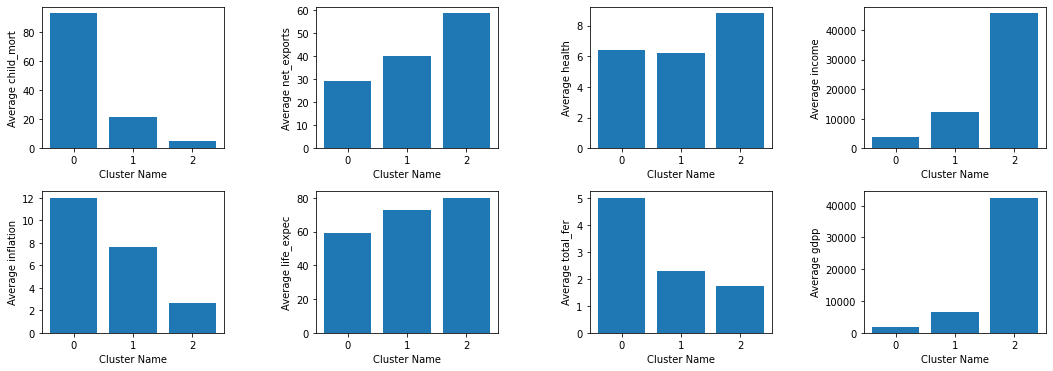

In [20]:
clusters = [0, 1, 2]

fig = plt.figure(figsize = (18,6))
plt.subplot(2,4,1)
plt.bar(clusters, child_mort_list)
plt.xlabel('Cluster Name')
plt.ylabel('Average child_mort')

plt.subplot(2,4,2)
plt.bar(clusters, net_exports_list)
plt.xlabel('Cluster Name')
plt.ylabel('Average net_exports')

plt.subplot(2,4,3)
plt.bar(clusters, health_list)
plt.xlabel('Cluster Name')
plt.ylabel('Average health')

plt.subplot(2,4,4)
plt.bar(clusters, income_list)
plt.xlabel('Cluster Name')
plt.ylabel('Average income')

plt.subplot(2,4,5)
plt.bar(clusters, inflation_list)
plt.xlabel('Cluster Name')
plt.ylabel('Average inflation')

plt.subplot(2,4,6)
plt.bar(clusters, life_expec_list)
plt.xlabel('Cluster Name')
plt.ylabel('Average life_expec')

plt.subplot(2,4,7)
plt.bar(clusters, total_fer_list)
plt.xlabel('Cluster Name')
plt.ylabel('Average total_fer')

plt.subplot(2,4,8)
plt.bar(clusters, gdpp)
plt.xlabel('Cluster Name')
plt.ylabel('Average gdpp')

plt.subplots_adjust(wspace = .5, hspace = .3)